In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set style for better visualizations
plt.style.use('seaborn')
sns.set_theme(style="darkgrid")

In [4]:
# Define the stock and date range
symbol = 'NVDA'  # NVIDIA stock
start_date = '2020-01-01'
end_date = '2023-12-31'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)

# Save raw data
df.to_csv('../data/raw/nvidia_stock.csv')

# Display first few rows
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (1006, 6)
***********************]  1 of 1 completed

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,5.96875,5.99775,5.91800,5.99775,5.972710,237536000
2020-01-03,5.87750,5.94575,5.85250,5.90175,5.877112,205384000
2020-01-06,5.80800,5.93175,5.78175,5.92650,5.901757,262636000
2020-01-07,5.95500,6.04425,5.90975,5.99825,5.973210,314856000
2020-01-08,5.99400,6.05100,5.95375,6.00950,5.984413,277108000


In [5]:
# Basic statistics
print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Basic Statistics:
              Open         High          Low        Close    Adj Close  \
count  1006.000000  1006.000000  1006.000000  1006.000000  1006.000000   
mean     21.085426    21.479479    20.679187    21.098424    21.070585   
std      11.768098    11.933881    11.570665    11.754605    11.756655   
min       5.002500     5.248500     4.517000     4.910000     4.892427   
25%      13.138000    13.383875    12.950187    13.152562    13.127090   
50%      17.512376    17.930500    17.060250    17.606999    17.574623   
75%      26.550500    27.004500    26.175499    26.529250    26.508283   
max      50.216000    50.548000    49.411999    50.409000    50.390282   

             Volume  
count  1.006000e+03  
mean   4.642033e+08  
std    1.897755e+08  
min    9.788400e+07  
25%    3.314385e+08  
50%    4.373750e+08  
75%    5.657198e+08  
max    1.543911e+09  

Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: in

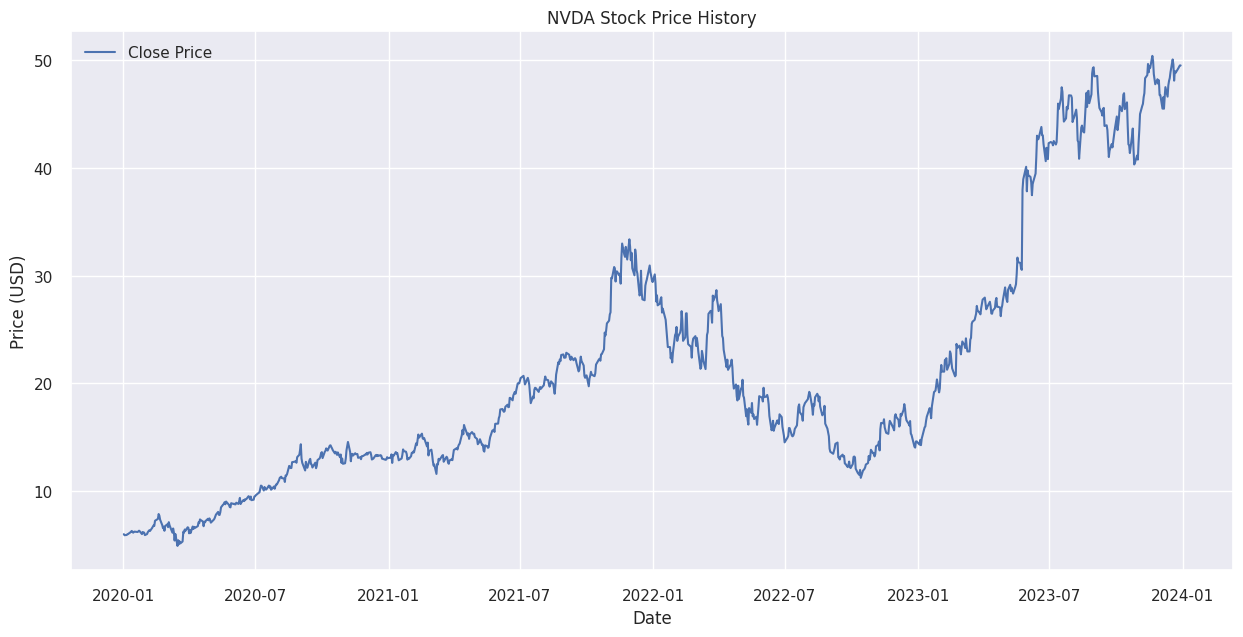

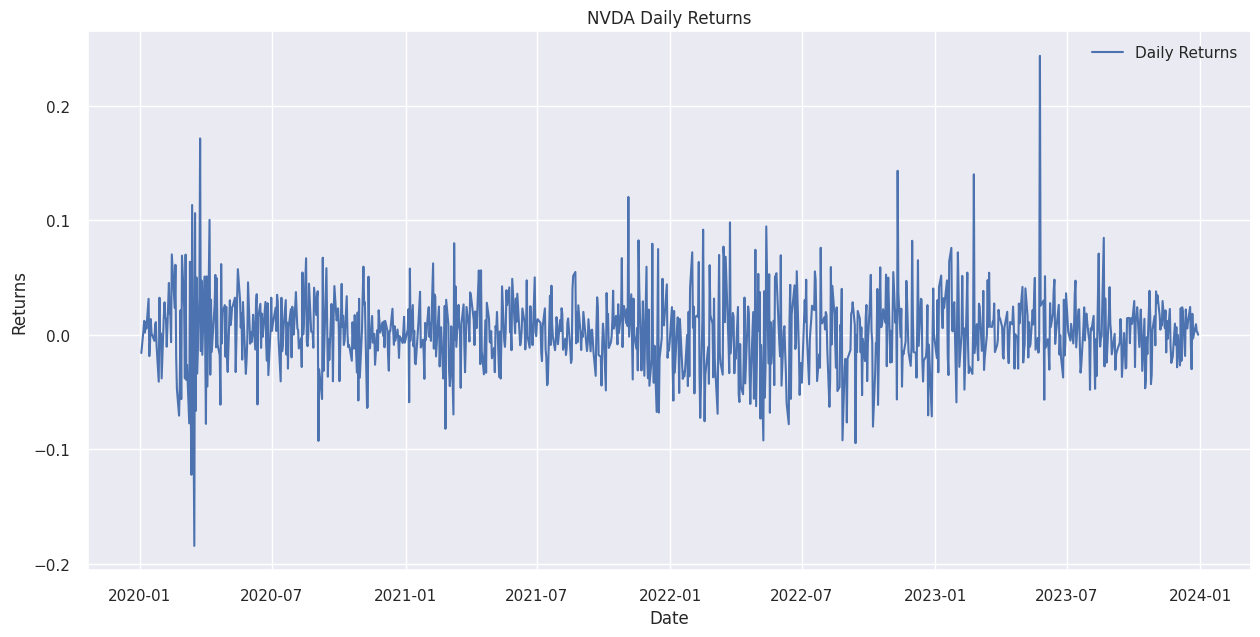

In [6]:
# Plotting stock price trends
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title(f'{symbol} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot daily returns
plt.figure(figsize=(15, 7))
daily_returns = df['Close'].pct_change()
plt.plot(df.index, daily_returns, label='Daily Returns')
plt.title(f'{symbol} Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

Dataset with new features:


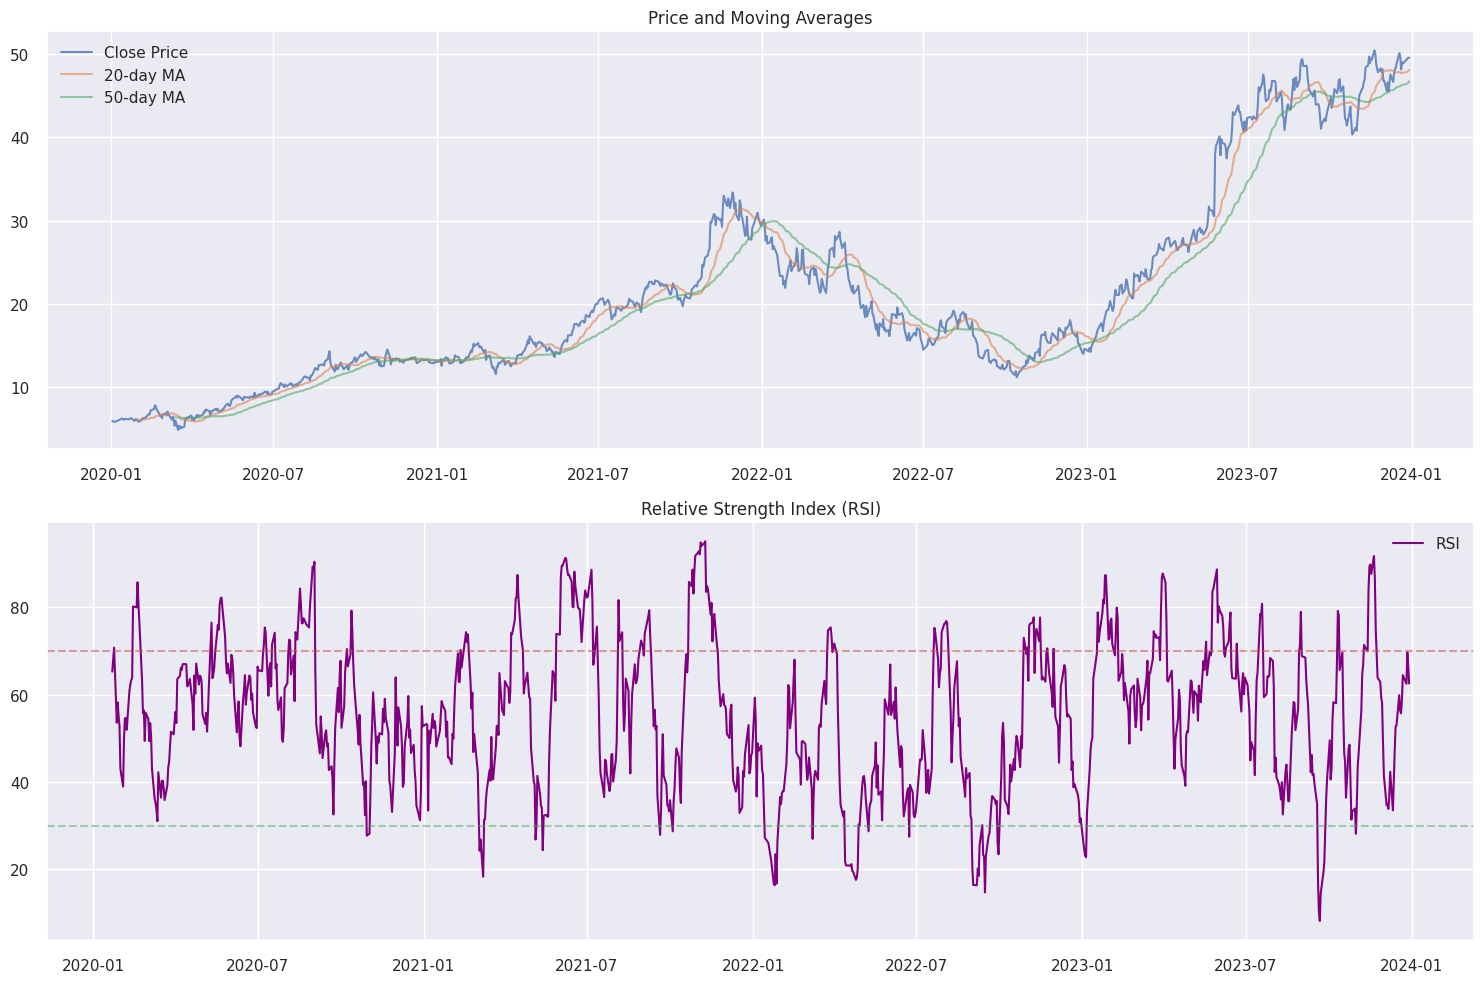

In [7]:
def add_technical_indicators(df):
    # Moving averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Trading Volume Features
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    
    return df

# Add technical indicators
df = add_technical_indicators(df)

# Display the new features
print("Dataset with new features:")
df.tail()

# Let's visualize the technical indicators
plt.figure(figsize=(15, 10))

# Plot price and moving averages
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.8)
plt.plot(df.index, df['MA20'], label='20-day MA', alpha=0.6)
plt.plot(df.index, df['MA50'], label='50-day MA', alpha=0.6)
plt.title('Price and Moving Averages')
plt.legend()

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(df.index, df['RSI'], label='RSI', color='purple')
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)
plt.title('Relative Strength Index (RSI)')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
def prepare_data_for_lstm(df, lookback=60):
    # Select features for the model
    features = ['Close', 'Volume', 'MA20', 'MA50', 'RSI', 'Volume_MA20']
    data = df[features].copy()
    
    # Handle missing values
    data = data.dropna()
    
    # Scale the features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Create sequences for LSTM
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i])
        y.append(scaled_data[i, 0])  # Predicting the Close price
    
    X, y = np.array(X), np.array(y)
    
    # Split into train and test sets (80-20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler

# Prepare data for LSTM
X_train, X_test, y_train, y_test, scaler = prepare_data_for_lstm(df)

# Save processed data
np.save('../data/processed/X_train.npy', X_train)
np.save('../data/processed/X_test.npy', X_test)
np.save('../data/processed/y_train.npy', y_train)
np.save('../data/processed/y_test.npy', y_test)

print("Data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data shapes:
X_train shape: (717, 60, 6)
X_test shape: (180, 60, 6)
y_train shape: (717,)
y_test shape: (180,)
